In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')

import plotly
import plotly.graph_objs as go
import plotly.express as px
from bokeh.palettes import Category20, Viridis3, Set1
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import DataManager
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import importlib
importlib.reload(DataManager)

palette1 = Category20
palette2 = Viridis3


In [3]:
dm = DataManager.DataManager()
control_samples = dm.get_control_samples()
scaler = StandardScaler()
ftr_data = scaler.fit_transform(dm.data.values[:,3:])
ftr_data = dm.data.values[:,3:]

In [4]:
pca = PCA(n_components=50)
pca.fit(ftr_data)


perm_expl_vars = []
N_PERM = 20
for i in tqdm(range(N_PERM)):
    pca_perm = PCA(n_components=50)
    data = ftr_data.copy()
    for j in range(data.shape[1]):
        np.random.shuffle(data[:, j])
    pca_perm.fit(data)
    perm_expl_vars.append(pca_perm.explained_variance_ratio_)
perm_expl_vars = np.array(perm_expl_vars)
rel_component = int((np.sum(perm_expl_vars<pca.explained_variance_ratio_, axis=0)/N_PERM).sum())
print("Number of PCs that do better than chance: {}".format(int(rel_component)))


Number of PCs that do better than chance: 5


In [5]:
pca = PCA(n_components=int(rel_component))
pca_embedding = pca.fit_transform(ftr_data)

In [19]:
n_neighbors = 100

descriptions = []
distance_matrices = []
#embedding = umap_embedding_3d

for cl in range(12):
    for rep in range(2):
        idxs = (dm.data["cell_line"]==cl) & (dm.data["replicate"] == rep)
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(pca_embedding[idxs,:])
        distance_matrix = nbrs.kneighbors_graph(pca_embedding[idxs,:]).toarray()
        distance_matrix = np.where((distance_matrix + distance_matrix.T)/2> 0, 1, 0)
        distance_matrices.append(distance_matrix)
        descriptions.append("CL {} - Rep {}".format(cl, rep))

In [20]:
median_distance_mat = np.median(np.array(distance_matrices), axis=0)
mean_distance_mat = np.mean(np.array(distance_matrices), axis=0)

median_distance_mat.shape


(1372, 1372)

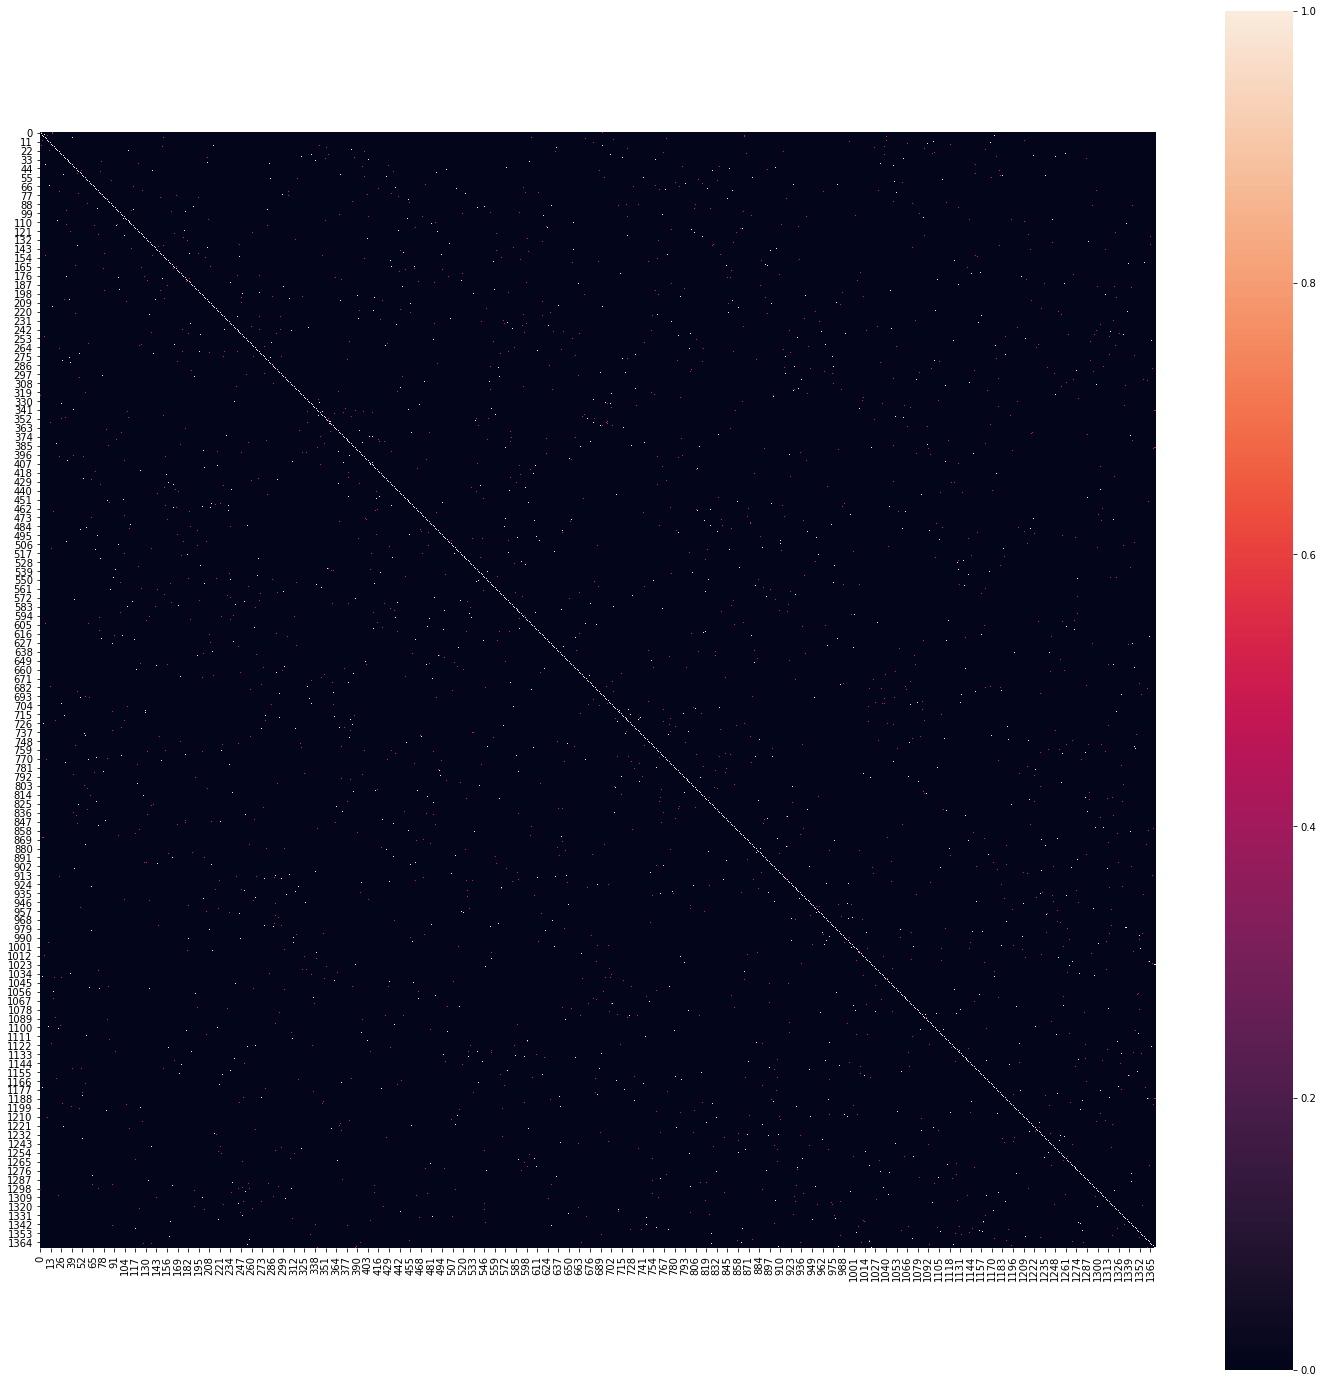

In [15]:
fig, axs = plt.subplots(figsize=(25, 25))
sns.heatmap(distance_matrices[0], ax=axs, square=True)
plt.show()
plt.close(fig)

In [21]:
np.sum(median_distance_mat)-1372

45.0

In [22]:
np.unique(distance_matrices[0])

array([0, 1])

## Using TL data 

In [37]:
tl_feature_data = np.load(os.path.join("data", "resnet34_512.npy"))
scaler = StandardScaler()
tl_feature_data = scaler.fit_transform(tl_feature_data)

In [38]:
pca = PCA(n_components=50)
pca.fit(tl_feature_data)


perm_expl_vars = []
N_PERM = 20
for i in tqdm(range(N_PERM)):
    pca_perm = PCA(n_components=50)
    data = tl_feature_data.copy()
    for j in range(data.shape[1]):
        np.random.shuffle(data[:, j])
    pca_perm.fit(data)
    perm_expl_vars.append(pca_perm.explained_variance_ratio_)
perm_expl_vars = np.array(perm_expl_vars)
rel_component = int((np.sum(perm_expl_vars<pca.explained_variance_ratio_, axis=0)/N_PERM).sum())
print("Number of PCs that do better than chance: {}".format(int(rel_component)))


Number of PCs that do better than chance: 26


In [39]:
pca = PCA(n_components=int(rel_component))
pca_embedding = pca.fit_transform(tl_feature_data)

In [40]:
n_neighbors = 50

descriptions = []
distance_matrices = []
#embedding = umap_embedding_3d

for cl in range(12):
    for rep in range(2):
        idxs = (dm.data["cell_line"]==cl) & (dm.data["replicate"] == rep)
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(pca_embedding[idxs,:])
        distance_matrix = nbrs.kneighbors_graph(pca_embedding[idxs,:]).toarray()
        distance_matrix = np.where((distance_matrix + distance_matrix.T)/2> 0, 1, 0)
        distance_matrices.append(distance_matrix)
        descriptions.append("CL {} - Rep {}".format(cl, rep))

In [41]:
median_distance_mat = np.median(np.array(distance_matrices), axis=0)
mean_distance_mat = np.mean(np.array(distance_matrices), axis=0)

median_distance_mat.shape


(1372, 1372)

In [42]:
np.sum(median_distance_mat)-1372

0.0

In [43]:
median_distance_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [44]:
mean_distance_mat

array([[1.        , 0.        , 0.08333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       [0.08333333, 0.04166667, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04166667],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04166667, 0.        ,
        1.        ]])

In [36]:
pca.explained_variance_ratio_[:5].sum()

0.9088597438523005

In [46]:
np.unique(mean_distance_mat)

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 1.        ])